# Captcha Solver - Navia Life Care Assignment

In [1]:
import os
import os.path
import cv2
import glob
import imutils

In [2]:
import matplotlib.pyplot as plt

In [3]:
cv2.__version__

'4.5.1'

## Input training images

In [4]:
CAPTCHA_IMAGE_FOLDER  = r"C:\Users\Piyush\Desktop\Navia Life - Assignement\Backend Assignment (1)\Assignment\electoral-tagged"

In [5]:
captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER,'*'))
counts = {}

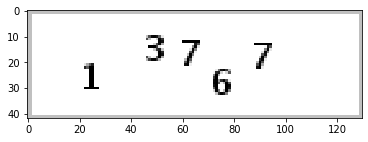

In [22]:
# printing a random captcha 
captcha_image_file = captcha_image_files[1]
for i in range(1):
    sample_image = cv2.imread(captcha_image_file)
    plt.imshow(sample_image)

## Break the captcha to individual numbers separately

### Store all the separated numbers in some output folder

In [6]:
OUTPUT_FOLDER = r"C:\Users\Piyush\Desktop\Navia Life - Assignement\Backend Assignment (1)\Assignment\Output_letter_images"

In [7]:
for (i, captcha_image_file) in enumerate(captcha_image_files):
    print("Processing image {}/{}".format(i + 1, len(captcha_image_files)))

    # Since the filename contains the captcha text (i.e. "2A2X.png" has the text "2A2X"),
    # grab the base filename as the text
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]
    
    # Load the image and convert it to grayscale
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Add some extra padding around the image
    gray = cv2.copyMakeBorder(gray, 0, 0, 0, 0, cv2.BORDER_REPLICATE)
    
    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    # find the contours (continuous blobs of pixels) the image - breaks the images to individual number images
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = contours[0]  
    letter_image_regions = []
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)
        # Compare the width and height of the contour to detect letters that may be overlapping.
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))
            
    # If we found more or less than 5 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 5:
        continue
        
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    
    # Save out each letter as a single image
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]

        # Get the folder to save the image in
        save_path = os.path.join(OUTPUT_FOLDER, letter_text)

        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)

        # increment the count for the current key
        counts[letter_text] = count + 1

Processing image 1/940
Processing image 2/940
Processing image 3/940
Processing image 4/940
Processing image 5/940
Processing image 6/940
Processing image 7/940
Processing image 8/940
Processing image 9/940
Processing image 10/940
Processing image 11/940
Processing image 12/940
Processing image 13/940
Processing image 14/940
Processing image 15/940
Processing image 16/940
Processing image 17/940
Processing image 18/940
Processing image 19/940
Processing image 20/940
Processing image 21/940
Processing image 22/940
Processing image 23/940
Processing image 24/940
Processing image 25/940
Processing image 26/940
Processing image 27/940
Processing image 28/940
Processing image 29/940
Processing image 30/940
Processing image 31/940
Processing image 32/940
Processing image 33/940
Processing image 34/940
Processing image 35/940
Processing image 36/940
Processing image 37/940
Processing image 38/940
Processing image 39/940
Processing image 40/940
Processing image 41/940
Processing image 42/940
P

In [8]:
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense

Using TensorFlow backend.
C:\Users\Piyush\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Piyush\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Piyush\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Piyush\anaconda3\lib\site-packages\tensorflow\python\framework\dtype

In [9]:
def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    :param image: image to resize
    :param width: desired width in pixels
    :param height: desired height in pixels
    :return: the resized image
    """

    # grab the dimensions of the image, then initialize
    # the padding values
    (h, w) = image.shape[:2]

    # if the width is greater than the height then resize along
    # the width
    if w > h:
        image = imutils.resize(image, width=width)

    # otherwise, the height is greater than the width so resize
    # along the height
    else:
        image = imutils.resize(image, height=height)

    # determine the padding values for the width and height to
    # obtain the target dimensions
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any
    # rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    # return the pre-processed image
    return image

In [10]:
img_list = []

## Creating our X - image and Y-output label/class

In [11]:
# initialize the data and labels
X = []
Y = []
i = 0
# loop over the input images
for image_file in paths.list_images(OUTPUT_FOLDER ):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    img_list.append(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]
    i = i + 1;
    # Add the letter image and it's label to our training data
    X.append(image)
    Y.append(label)
print(i)  # tells total numbers

4700


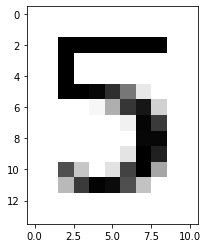

In [12]:
plt.imshow(img_list[2428])

In [14]:
# Normalization
X = np.array(X, dtype="float") / 255.0
Y = np.array(Y)

In [16]:
print(X.shape)
print(Y.shape)

(4700, 20, 20, 1)
(4700,)


## Creating our CNN model

In [17]:
# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.25, random_state=0)

In [18]:
# Convert the labels (letters) into one-hot encodings that Keras can work with since it is multiclass
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

In [19]:
# Build the neural network!
model = Sequential()

# First convolutional layer with max pooling, Note: (20,20,1) is the 20*20 pixel we have converted all our numbers to
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# Output layer with 9 nodes (one for each possible number we predict)
model.add(Dense(9, activation="softmax"))

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the neural network
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10, verbose=1)



Train on 3525 samples, validate on 1175 samples
Epoch 1/10
3525/3525 [==============================] - 3s 927us/step - loss: 0.3979 - accuracy: 0.9189 - val_loss: 0.0194 - val_accuracy: 0.9983
Epoch 2/10
3525/3525 [==============================] - 3s 868us/step - loss: 0.0211 - accuracy: 0.9983 - val_loss: 0.0224 - val_accuracy: 0.9983
Epoch 3/10
3525/3525 [==============================] - 3s 920us/step - loss: 0.0198 - accuracy: 0.9983 - val_loss: 0.0201 - val_accuracy: 0.9983
Epoch 4/10
3525/3525 [==============================] - 3s 958us/step - loss: 0.0169 - accuracy: 0.9983 - val_loss: 0.0249 - val_accuracy: 0.9983
Epoch 5/10
3525/3525 [==============================] - 3s 976us/step - loss: 0.0177 - accuracy: 0.9983 - val_loss: 0.0200 - val_accuracy: 0.9983
Epoch 6/10
3525/3525 [==============================] - 4s 997us/step - loss: 0.0180 - accuracy: 0.9983 - val_loss: 0.0185 - val_accuracy: 0.9983
Epoch 7/10
3525/3525 [==============================] - 3s 980us/step - lo

### Excellent accuracy of 99.8% on the validation test set!!

## Testing with test captcha images

In [20]:
TEST_IMAGES = r"C:\Users\Piyush\Desktop\Navia Life - Assignement\Backend Assignment (1)\Assignment\electoral-captchas"

CAPTCHA text is: 18878
CAPTCHA text is: 13767
CAPTCHA text is: 22649
CAPTCHA text is: 81738
CAPTCHA text is: 65887
CAPTCHA text is: 82896
CAPTCHA text is: 95792
CAPTCHA text is: 17567
CAPTCHA text is: 67449
CAPTCHA text is: 87152


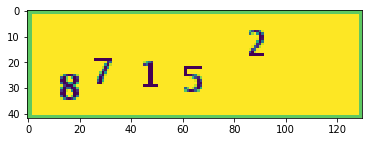

In [21]:
# Grab some random CAPTCHA images to test against.
captcha_image_files = list(paths.list_images(TEST_IMAGES))
# choose 10 random 10 test images
captcha_image_files = np.random.choice(captcha_image_files, size=(10,), replace=False)

# loop over the image paths and breaking them into individual numbers as done for training captchas
for image_file in captcha_image_files:
    i=i+1
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Add some extra padding around the image
    image = cv2.copyMakeBorder(image, 0, 0, 0, 0, cv2.BORDER_REPLICATE)

    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    plt.imshow(image)
    # find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Hack for compatibility with different OpenCV versions
    if imutils.is_cv3():
        #print("a")
        contours = contours[1]
    else:
        #print("b")
        contours = contours[0]

    letter_image_regions = []

    # Now we can loop through each of the four contours and extract the letter
    # inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.25:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h)) 
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            # This is a normal letter by itself
            letter_image_regions.append((x, y, w, h))

    # If we found more or less than 5 letters in the captcha, our letter extraction
    # didn't work correcly. Skip the image instead of saving bad training data!
    if len(letter_image_regions) != 5:
        continue

    # Sort the detected letter images based on the x coordinate to make sure
    # we are processing them from left-to-right so we match the right image
    # with the right letter
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    #print(letter_image_regions)
    # Create an output image and a list to hold our predicted letters
    output = cv2.merge([image] * 3)
    predictions = []

    # loop over the letters
    i=0
    for letter_bounding_box in letter_image_regions:
        # Grab the coordinates of the letter in the image
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]

        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)

        # Turn the single image into a 4d list of images to make Keras happy
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = np.expand_dims(letter_image, axis=0)

        # Ask the neural network to make a prediction
        prediction = model.predict(letter_image)

        # Convert the one-hot-encoded prediction back to a normal letter
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

        # draw the prediction on the output image
        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.55, (255, 0, 0), 2)

    # Print the captcha's text
    captcha_text = "".join(predictions)
    print("CAPTCHA text is: {}".format(captcha_text))

     #Show the annotated image
    cv2.imshow("Output", output)
    
    cv2.waitKey(0)
    
    

### Press any key on keyboard to get continous captcha predictions
### The image show above is for last input captcha